# Timing Functions

This notebook has the results of timing various CSR functions.

In [1]:
import timeit

In [2]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

In [3]:
    from tqdm.auto import tqdm

In [4]:
from csr import CSR

In [5]:
np.random.seed(20210202)

## Matrix Multiply

Let's do some matrix multiplication - a quick timing of two functions on a single matrix:

In [6]:
A = sps.random(100, 500, 0.1, format='csr')
B = sps.random(500, 200, 0.2, format='csr')

Convert to CSR, and do one multiplication to compile the kernel:

In [7]:
Ac = CSR.from_scipy(A)
Bc = CSR.from_scipy(B)
Cc = Ac.multiply(Bc)

SciPy:

In [8]:
%timeit C = A @ B

1000 loops, best of 5: 695 µs per loop


CSR with Numba kernel:

In [9]:
%timeit Cc = Ac.multiply(Bc)

1000 loops, best of 5: 863 µs per loop


Let's start sweeping timings. We'll make a function to do this:

In [39]:
NRUNS = 1000
def time_multiply(m, n, l, dens, op, number=NRUNS):
    A = sps.random(m, n, dens, format='csr')
    B = sps.random(n, l, dens, format='csr')
    A = op.prepare(A)
    B = op.prepare(B)
        
    def func():
        op(A, B)
    
    return timeit.timeit(func, number=number)

In [40]:
def op_sps_mult(A, B):
    A @ B
op_sps_mult.prepare = lambda x: x

def op_csr_mult(A, B):
    A.multiply(B)
op_csr_mult.prepare = CSR.from_scipy

In [41]:
time_multiply(100, 100, 100, 0.1, op_sps_mult)

0.19204849999914586

In [42]:
time_multiply(100, 100, 100, 0.1, op_csr_mult)

0.2633488999999827

In [43]:
%prun time_multiply(100, 100, 100, 0.1, op_sps_mult, 10000)

In [45]:
%prun time_multiply(1000, 1000, 1000, 0.1, op_csr_mult, 500)

### Sweep by Density

Let's measure time by the matrix density for a fixed size (100x100x100):

In [46]:
densities = np.linspace(0, 1, 10)
sps_times = [time_multiply(100, 100, 100, d, op_sps_mult) for d in tqdm(densities)]
csr_times = [time_multiply(100, 100, 100, d, op_csr_mult) for d in tqdm(densities)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

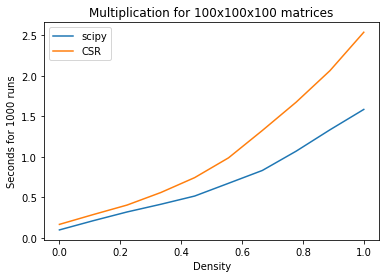

In [47]:
plt.plot(densities, sps_times, label='scipy')
plt.plot(densities, csr_times, label='CSR')
plt.xlabel('Density')
plt.ylabel(f'Seconds for {NRUNS} runs')
plt.title('Multiplication for 100x100x100 matrices')
plt.legend()

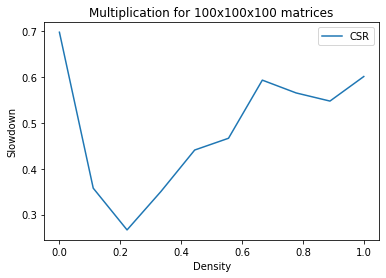

In [49]:
plt.plot(densities, np.array(csr_times) / sps_times - 1, label='CSR')
plt.xlabel('Density')
plt.ylabel(f'Slowdown')
plt.title('Multiplication for 100x100x100 matrices')
plt.legend()

### Sweep by Size

Let's measure for a square matrix with fixed density (0.1).

In [50]:
sizes = [5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000, 5000]
sps_times = [time_multiply(s, s, s, 0.1, op_sps_mult) for s in tqdm(sizes)]
csr_times = [time_multiply(s, s, s, 0.1, op_csr_mult) for s in tqdm(sizes)]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

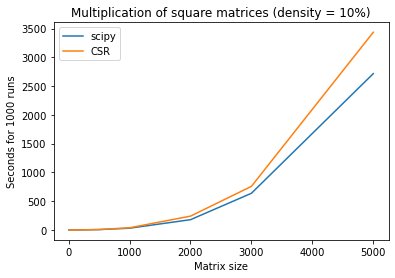

In [52]:
plt.plot(sizes, sps_times, label='scipy')
plt.plot(sizes, csr_times, label='CSR')
plt.xlabel('Matrix size')
plt.ylabel(f'Seconds for {NRUNS} runs')
plt.title('Multiplication of square matrices (density = 10%)')
plt.legend()